<a href="https://colab.research.google.com/github/rameez-anwar/pneumonia-detection-using-alexnet/blob/main/Pneumonia_Detection_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rameezmughal","key":"86596eee30b913c8a0d37e5e071cc24c"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


# **Dataset Path:**

In [4]:
import os
dataset_path = "/content/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# **Import Libraries**

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# **Define Data Preprocessing & DataLoader**

In [7]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [8]:
# Load Datasets with Transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Handle Class Imbalance using Weighted Sampling
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in train_dataset.classes]
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [weights[label] for _, label in train_dataset.samples]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
batch_size = 32

#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# **Define AlexNet Model**

In [9]:
# Define AlexNet Model
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNetModified, self).__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.model(x)

#  Initialize Model
model = AlexNetModified(num_classes=2).to(device)

#Define Loss Function (With Class Weights) & Optimizer
class_weights = torch.tensor([2.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 170MB/s]


# **Train the Model**

In [10]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/5], Loss: 0.1944, Accuracy: 91.07%
Epoch [2/5], Loss: 0.1079, Accuracy: 95.38%
Epoch [3/5], Loss: 0.0885, Accuracy: 96.30%
Epoch [4/5], Loss: 0.0919, Accuracy: 96.07%
Epoch [5/5], Loss: 0.0718, Accuracy: 97.20%


# **Evaluate the Model**


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.92      0.87       234
   PNEUMONIA       0.95      0.89      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.91      0.90      0.90       624



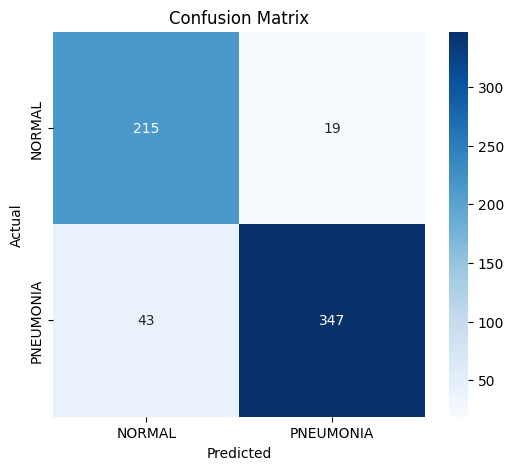

In [11]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

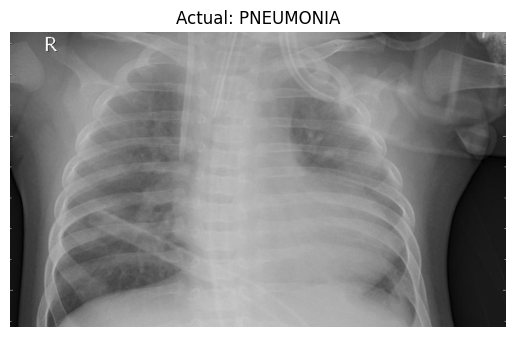


Predicted: PNEUMONIA


In [12]:
import random
from PIL import Image
test_class = random.choice(os.listdir(test_dir))
test_img_path = os.path.join(test_dir, test_class, random.choice(os.listdir(os.path.join(test_dir, test_class))))

image = Image.open(test_img_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title(f"Actual: {test_class}")
plt.show()

image = test_transforms(image).unsqueeze(0)

# Move the image to the same device as the model
image = image.to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    _, pred = torch.max(output, 1)

predicted_class = train_dataset.classes[pred.item()]
print(f"\nPredicted: {predicted_class}" if predicted_class == test_class else f"Predicted: {predicted_class}")

In [13]:
from torchvision.transforms import functional as TF

def is_grayscale(image, threshold=0.05):
    # Image is expected as PIL
    image = TF.to_tensor(image)
    if image.shape[0] == 1:
        return True
    else:
        r, g, b = image[0], image[1], image[2]
        diff_rg = (r - g).abs().mean()
        diff_rb = (r - b).abs().mean()
        diff_gb = (g - b).abs().mean()
        avg_diff = (diff_rg + diff_rb + diff_gb) / 3
        return avg_diff < threshold


Saving 76052f7902246ff862f52f5d3cd9cd_gallery.jpg to 76052f7902246ff862f52f5d3cd9cd_gallery.jpg


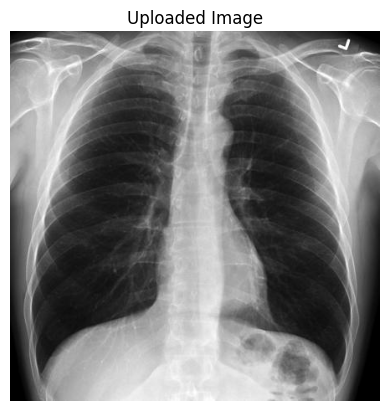

AI Prediction: NORMAL


In [14]:
# Upload image
uploaded = files.upload()

img_name = list(uploaded.keys())[0]
image = Image.open(img_name).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

# Check if it looks like a grayscale X-ray
if not is_grayscale(image):
    print("The uploaded image does not appear to be a chest X-ray!")
else:
    # Preprocess and Predict
    image = test_transforms(image).unsqueeze(0)

    # Move the image to the same device as the model
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    predicted_class = train_dataset.classes[pred.item()]
    print(f"AI Prediction: {predicted_class}")

In [15]:
import torch

torch.save(model.state_dict(), "pneumonia_model.pth")


In [16]:
! pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [17]:
import torch
import torchvision.transforms as transforms
import gradio as gr
from PIL import Image
import torchvision.models as models
import torch.nn as nn
from torchvision.transforms import functional as TF

# Define the Model
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNetModified, self).__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.model(x)

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetModified(num_classes=2)
model.load_state_dict(torch.load("pneumonia_model.pth", map_location=device))
model.to(device)
model.eval()

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Class Labels and Medical Advice
class_labels = ["Normal", "Pneumonia"]

medical_advice = {
    "Normal": """
**Healthy Lungs Detected**
Your chest X-ray appears **normal**. However, if you experience any symptoms like cough, fever, or shortness of breath, consider a routine medical checkup.

**Health Recommendations:**
- Stay active with regular exercise
- Avoid smoking and air pollution
- Maintain a healthy diet and hydration
- Schedule periodic health screenings
    """,

    "Pneumonia": """
**Possible Pneumonia Detected**
Your chest X-ray shows **abnormalities** that may indicate pneumonia. **Immediate medical consultation is recommended.**

**Suggested Next Steps:**
- Visit a pulmonologist
- Get additional medical tests and X-rays
- Increase rest and hydration
- Follow prescribed medications and breathing exercises
    """
}

# Function to check if the image is grayscale
def is_grayscale(image, threshold=0.05):
    # Convert image to tensor (C, H, W)
    image = TF.to_tensor(image)
    if image.shape[0] == 1:  # Grayscale image
        return True
    else:
        r, g, b = image[0], image[1], image[2]
        diff_rg = (r - g).abs().mean()
        diff_rb = (r - b).abs().mean()
        diff_gb = (g - b).abs().mean()
        avg_diff = (diff_rg + diff_rb + diff_gb) / 3
        return avg_diff < threshold

# Prediction Function
def predict(image):
    image = Image.fromarray(image)

    # Check if the image is grayscale (potential X-ray)
    if not is_grayscale(image):
        return "**Warning**: The uploaded image does not appear to be a chest X-ray! Please upload a grayscale X-ray image."

    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    diagnosis = class_labels[predicted.item()]
    confidence_score = confidence.item() * 100

    result_text = f"**Diagnosis Result:** {diagnosis}\n\n" \
                  f"**Confidence Score:** {confidence_score:.2f}%\n\n" \
                  f"{medical_advice[diagnosis]}"

    return result_text

# Gradio Interface (Using Default Theme)
with gr.Blocks() as iface:
    gr.Markdown("<h1>AI-Based Pneumonia Detection System</h1>")
    gr.Markdown("<h3>Upload a chest X-ray to check for pneumonia using our advanced AI model.</h3>")

    with gr.Row():
        image_input = gr.Image(type="numpy", label="Upload Chest X-ray")
        result_output = gr.Markdown(label="Diagnosis Report")

    # Add example images for normal and pneumonia cases
    examples = [
        ["/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg"],  # Replace with actual path to normal X-ray example
        ["/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"]  # Replace with actual path to pneumonia X-ray example
    ]

    # Button for analysis
    predict_button = gr.Button("Analyze X-ray")

    # Adding a progress bar
    with gr.Row():
        progress = gr.Progress()

    predict_button.click(predict, inputs=image_input, outputs=result_output, show_progress=True)

    # Example Images added
    gr.Examples(
        examples=examples,
        inputs=image_input,
        outputs=result_output,
    )

    gr.Markdown("""
    **Disclaimer:** This AI model is intended for **educational purposes only** and should not replace professional medical consultation. Always seek guidance from a qualified doctor.
    """)

iface.launch()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://94c7d281f63e3582ed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
